# Comprehensive Fitting Comparison Analysis

This notebook analyzes differences between DFT-constrained and free-model fitting results across three energy regions:

1. **Long q range (250.0, 283.7)**: Energies with extended q-range measurements
2. **Pre-edge (>250, <283.7)**: Pre-edge delta crossing energies  
3. **Resonant (>283.7)**: Resonant energies

For each region, we analyze:
- Fit quality metrics (χ², reduced χ², AIC, BIC, RMSD)
- Residuals and model-data differences
- Q-dependence of fit quality (cumulative metrics)
- Extrapolation behavior beyond data range


In [1]:
import os
import pickle
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pyref.fitting as fit
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import scienceplots

# Set up plotting style
plt.style.use(["science"])
plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 300
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

# Import helper functions
import sys
sys.path.insert(0, str(Path.cwd().parent / 'fitting'))
from helper import aic, bic, reduced_chi2, rxr, anisotropy

# Define additional helper functions
def chi2(obj):
    """Calculate chi-squared."""
    return obj.chisqr()

def rmsd(obj):
    """Calculate RMSD."""
    return np.sqrt(obj.chisqr() / obj.npoints)

def load_reflectivity_dataset(filename):
    """Load reflectivity dataset from parquet file."""
    df_load = pl.read_parquet(filename)
    data_reconstructed = {}
    for group_key, group_data in df_load.group_by("energy"):
        energy_val = group_key[0]
        Q = group_data["Q"].to_numpy()
        R = group_data["R"].to_numpy()
        dR = group_data["dR"].to_numpy()
        dataset = fit.XrayReflectDataset(data=(Q, R, dR))
        data_reconstructed[str(energy_val)] = dataset
    print(f"Dataset loaded from {filename}")
    return data_reconstructed


## Load Data and Fitting Results


In [2]:
# Paths
base_path = Path.cwd().parent / 'fitting'
data_path = base_path / 'reflectivity_data.parquet'

# Load data
print("Loading reflectivity data...")
loaded_data = load_reflectivity_dataset(data_path)

# Load fitting results
print("Loading fitting results...")
with open(base_path / 'fitting_results_fixed.pkl', 'rb') as f:
    results_fixed = pickle.load(f)
with open(base_path / 'fitting_results_fixed_2.pkl', 'rb') as f:
    results_fixed_2 = pickle.load(f)
with open(base_path / 'fitting_results_free_model.pkl', 'rb') as f:
    results_free = pickle.load(f)
with open(base_path / 'fitting_results_free_model_2.pkl', 'rb') as f:
    results_free_2 = pickle.load(f)

# Organize objectives by energy
def get_objectives_dict(results):
    return {obj.model.energy: obj for obj in results.objectives}

objectives_fixed = get_objectives_dict(results_fixed)
objectives_fixed_2 = get_objectives_dict(results_fixed_2)
objectives_free = get_objectives_dict(results_free)
objectives_free_2 = get_objectives_dict(results_free_2)

# Get all energies
all_energies = sorted(set(
    list(objectives_fixed.keys()) +
    list(objectives_fixed_2.keys()) +
    list(objectives_free.keys()) +
    list(objectives_free_2.keys())
))

print(f"\nLoaded {len(all_energies)} unique energies")
print(f"Energies: {all_energies}")


Loading reflectivity data...
Dataset loaded from /home/hduva/projects/xrr_notebooks/fitting/reflectivity_data.parquet
Loading fitting results...

Loaded 21 unique energies
Energies: [np.float64(250.0), np.float64(275.0), np.float64(280.0), np.float64(281.0), np.float64(281.2), np.float64(281.4), np.float64(281.6), np.float64(281.8), np.float64(282.0), np.float64(282.3), np.float64(282.5), np.float64(282.7), np.float64(282.9), np.float64(283.1), np.float64(283.3), np.float64(283.5), np.float64(283.7), np.float64(284.2), np.float64(285.1), np.float64(287.0), np.float64(289.0)]


In [3]:
def classify_energy_regions(energies: List[float]) -> Dict[str, List[float]]:
    """Classify energies into three regions."""
    regions = {
        'long_q': [],      # (250.0, 283.7)
        'pre_edge': [],    # (>250, <283.7)
        'resonant': []     # (>283.7)
    }

    for e in energies:
        if e == 250.0:
            regions['long_q'].append(e)
        elif 250.0 < e < 283.7:
            regions['pre_edge'].append(e)
        elif e >= 283.7:
            regions['resonant'].append(e)

    return regions

regions = classify_energy_regions(all_energies)

print("Energy regions:")
print(f"  Long q range (250.0, 283.7): {regions['long_q']}")
print(f"  Pre-edge (>250, <283.7): {regions['pre_edge']}")
print(f"  Resonant (>283.7): {regions['resonant']}")


Energy regions:
  Long q range (250.0, 283.7): [np.float64(250.0)]
  Pre-edge (>250, <283.7): [np.float64(275.0), np.float64(280.0), np.float64(281.0), np.float64(281.2), np.float64(281.4), np.float64(281.6), np.float64(281.8), np.float64(282.0), np.float64(282.3), np.float64(282.5), np.float64(282.7), np.float64(282.9), np.float64(283.1), np.float64(283.3), np.float64(283.5)]
  Resonant (>283.7): [np.float64(283.7), np.float64(284.2), np.float64(285.1), np.float64(287.0), np.float64(289.0)]


## Analysis Functions


In [5]:
def calculate_fit_metrics(objective) -> Dict[str, float]:
    """Calculate comprehensive fit metrics for an objective."""
    return {
        'chi2': chi2(objective),
        'reduced_chi2': reduced_chi2(objective),
        'aic': aic(objective),
        'bic': bic(objective),
        'rmsd': rmsd(objective),
        'npoints': objective.npoints,
        'nparams': len(objective.varying_parameters()),
    }

def calculate_residuals(objective, pol: str = 'both') -> Dict[str, np.ndarray]:
    """Calculate residuals for each polarization."""
    residuals = {}

    for p in ['s', 'p'] if pol == 'both' else [pol]:
        pol_data = getattr(objective.data, p)
        q = pol_data.x
        y_data = pol_data.y
        y_err = pol_data.y_err

        # Get model prediction
        y_model = rxr(q, objective.model, p)

        # Calculate residuals
        residual = y_data - y_model
        normalized_residual = residual / y_err

        residuals[p] = {
            'q': q,
            'residual': residual,
            'normalized_residual': normalized_residual,
            'data': y_data,
            'model': y_model,
            'error': y_err,
        }

    return residuals

def calculate_cumulative_metrics(
    objective,
    pol: str = 'both',
    sort_by_q: bool = True
) -> Dict[str, np.ndarray]:
    """Calculate cumulative fit metrics as more q points are added."""
    residuals_dict = calculate_residuals(objective, pol)

    cumulative = {}

    for p in ['s', 'p'] if pol == 'both' else [pol]:
        res = residuals_dict[p]
        q = res['q']
        normalized_residual = res['normalized_residual']

        if sort_by_q:
            sort_idx = np.argsort(q)
            q = q[sort_idx]
            normalized_residual = normalized_residual[sort_idx]

        # Cumulative chi2 (sum of squared normalized residuals)
        cumulative_chi2 = np.cumsum(normalized_residual**2)

        # Cumulative RMSD
        cumulative_rmsd = np.sqrt(cumulative_chi2 / np.arange(1, len(q) + 1))

        cumulative[p] = {
            'q': q,
            'cumulative_chi2': cumulative_chi2,
            'cumulative_rmsd': cumulative_rmsd,
            'npoints': np.arange(1, len(q) + 1),
        }

    return cumulative

def extrapolate_model(
    objective,
    q_extrapolated: np.ndarray,
    pol: str = 'both'
) -> Dict[str, np.ndarray]:
    """Calculate model predictions for q values outside the data range."""
    extrapolated = {}

    for p in ['s', 'p'] if pol == 'both' else [pol]:
        r_extrapolated = rxr(q_extrapolated, objective.model, p)
        extrapolated[p] = {
            'q': q_extrapolated,
            'r': r_extrapolated,
        }

    return extrapolated


In [6]:
def create_metrics_table(
    objectives_fixed: Dict[float, object],
    objectives_free: Dict[float, object],
    energies: List[float],
) -> pd.DataFrame:
    """Create a comprehensive metrics table comparing fixed vs free models."""
    rows = []

    for e in energies:
        if e not in objectives_fixed or e not in objectives_free:
            continue

        obj_fixed = objectives_fixed[e]
        obj_free = objectives_free[e]

        metrics_fixed = calculate_fit_metrics(obj_fixed)
        metrics_free = calculate_fit_metrics(obj_free)

        row = {
            'energy': e,
            'model_type': 'DFT',
            **metrics_fixed,
        }
        rows.append(row)

        row = {
            'energy': e,
            'model_type': 'Free',
            **metrics_free,
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    return df

# Create metrics tables for both file pairs
metrics_1 = create_metrics_table(objectives_fixed, objectives_free, all_energies)
metrics_2 = create_metrics_table(objectives_fixed_2, objectives_free_2, all_energies)

print("Metrics for fixed/free pair 1:")
display(metrics_1.groupby(['energy', 'model_type'])[['reduced_chi2', 'aic', 'bic', 'rmsd']].mean())

print("\nMetrics for fixed/free pair 2:")
display(metrics_2.groupby(['energy', 'model_type'])[['reduced_chi2', 'aic', 'bic', 'rmsd']].mean())


Metrics for fixed/free pair 1:


reduced_chi2          aic          bic      rmsd
energy model_type                                                  
250.0  DFT             5.370453  1320.167830  1394.861219  2.221488
       Free           15.500405  3879.600828  3915.169108  3.860302
275.0  DFT             4.622514   453.403759   510.113846  1.933917
       Free            0.279915    58.311980   101.519665  0.489081
280.0  DFT             4.296637   428.697309   485.597443  1.866483
       Free            0.281953    58.785497   102.137980  0.491234
281.0  DFT             4.355747   438.372949   495.461425  1.881235
       Free            0.278825    58.767198   102.263180  0.488869
281.2  DFT             4.629615   463.294965   520.383441  1.939475
       Free            0.145408    45.959190    89.455172  0.353038
281.4  DFT             4.246619   424.195681   481.095815  1.855587
       Free            0.336440    63.961805   107.314288  0.536604
281.6  DFT             4.500034   429.002884   485.132290  1.901802
       Free            0.231880    53.101109    95.866370  0.444080
281.8  DFT             4.654438   456.244997   512.955085  1.940583
       Free            0.232955    53.897810    97.105496  0.446174
282.0  DFT             5.418330   518.813023   575.331328  2.091514
       Free            0.316647    61.448153   104.509719  0.519775
282.3  DFT             5.153202   495.481769   552.000075  2.039702
       Free            0.291450    57.396267    97.766486  0.501340
282.5  DFT             5.544442   518.821970   574.951375  2.110990
       Free            0.348230    62.037149   102.129581  0.547186
282.7  DFT             5.016624   588.812055   649.030279  2.050914
       Free            0.257673    59.632377   102.645394  0.477432
282.9  DFT             4.678136   556.594934   616.974077  1.981970
       Free            0.296936    66.147678   112.150835  0.510558
283.1  DFT             5.277181   622.489934   682.869078  2.105047
       Free            0.295770    66.013505   112.016662  0.509554
283.3  DFT             4.801166   570.128301   630.507444  2.007863
       Free            0.412107    79.392257   125.395414  0.601476
283.5  DFT             8.164421   940.086272  1000.465416  2.618324
       Free            0.793056   123.201388   169.204546  0.834382
283.7  DFT            11.360421  3166.115886  3243.613434  3.248761
       Free            1.051203   326.336743   385.382495  0.997186
284.2  DFT            23.963521  2294.571009  2352.214584  4.425785
       Free            3.510686   379.557937   423.476851  1.738460
285.1  DFT            18.529694  1783.791214  1841.434789  3.891788
       Free           11.277450  1148.467514  1192.386428  3.115833
287.0  DFT            26.229445  2612.485611  2670.847205  4.647657
       Free            2.616952   301.546068   346.012044  1.505023
289.0  DFT            19.409622  1769.456343  1826.166431  3.962846
       Free            2.335530   251.539787   294.747473  1.412734


Metrics for fixed/free pair 2:


reduced_chi2          aic          bic      rmsd
energy model_type                                                  
250.0  DFT             5.736792  1407.356556  1482.049946  2.296007
       Free            2.456254   630.238384   676.477149  1.527405
275.0  DFT             3.788347   379.162911   435.872999  1.750748
       Free            4.637829   462.680307   511.288953  1.969495
280.0  DFT             2.909482   303.853378   360.753513  1.535916
       Free            4.344466   440.035364   488.806908  1.907867
281.0  DFT             2.914616   307.230041   364.318517  1.538871
       Free            6.430081   640.427641   689.360620  2.323075
281.2  DFT             3.160332   329.590218   386.678694  1.602426
       Free            4.101150   421.508146   470.441125  1.855273
281.4  DFT             2.797354   293.761867   350.662001  1.506030
       Free            6.933312   680.797976   729.569520  2.410185
281.6  DFT             3.032960   302.834543   358.963949  1.561315
       Free           10.705134   988.756906  1036.867825  2.984002
281.8  DFT             3.161934   323.412148   380.122235  1.599466
       Free            8.484271   816.552936   865.161582  2.663820
282.0  DFT             3.755189   372.456591   428.974897  1.741181
       Free           10.868443  1025.028329  1073.472591  3.012251
282.3  DFT             3.594770   358.339729   414.858035  1.703584
       Free            7.192589   695.718155   741.471069  2.463901
282.5  DFT             3.931182   380.081644   436.211050  1.777538
       Free            7.696050   726.644537   772.082627  2.544271
282.7  DFT             3.787213   454.806243   515.024467  1.781974
       Free            4.836083   580.477365   629.225451  2.050286
282.9  DFT             3.644519   442.897117   503.276261  1.749367
       Free            4.876598   587.055570   638.809122  2.050983
283.1  DFT             4.299381   514.931892   575.311036  1.900044
       Free            6.433124   762.942993   814.696544  2.355670
283.3  DFT             4.043446   486.779040   547.158183  1.842623
       Free            6.533278   774.260397   826.013949  2.373937
283.5  DFT             7.204164   834.458076   894.837220  2.459532
       Free            9.688902  1130.845910  1182.599461  2.890952
283.7  DFT            14.016312  3896.485855  3973.983404  3.608589
       Free            5.070128  1445.495474  1511.921944  2.182157
284.2  DFT            25.166793  2407.678586  2465.322161  4.535539
       Free           24.234708  2386.766678  2436.175456  4.521222
285.1  DFT            18.867194  1815.516207  1873.159782  3.927070
       Free           31.455512  3087.184634  3136.593412  5.150926
287.0  DFT            22.748625  2271.365277  2329.726871  4.328298
       Free           35.028836  3573.912477  3623.936700  5.452555
289.0  DFT            16.149728  1479.325757  1536.035845  3.614775
       Free           14.035021  1327.221978  1375.830624  3.426132

## Visualization Functions


In [7]:
def plot_residuals_comparison(
    objectives_fixed: Dict[float, object],
    objectives_free: Dict[float, object],
    energies: List[float],
    region_name: str,
    ax: Axes = None,
) -> Tuple[Figure, Axes]:
    """Plot residuals comparison for fixed vs free models."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    colors = plt.cm.tab20(np.linspace(0, 1, len(energies)))

    for i, e in enumerate(energies):
        if e not in objectives_fixed or e not in objectives_free:
            continue

        obj_fixed = objectives_fixed[e]
        obj_free = objectives_free[e]

        # Get residuals for both polarizations
        res_fixed = calculate_residuals(obj_fixed, 'both')
        res_free = calculate_residuals(obj_free, 'both')

        color = colors[i]

        # Plot s-polarization
        for p, marker in [('s', 'o'), ('p', 's')]:
            q_fixed = res_fixed[p]['q']
            norm_res_fixed = res_fixed[p]['normalized_residual']
            q_free = res_free[p]['q']
            norm_res_free = res_free[p]['normalized_residual']

            # Plot fixed model residuals
            ax.scatter(
                q_fixed,
                norm_res_fixed,
                marker=marker,
                color=color,
                alpha=0.6,
                s=20,
                label=f'{e:.1f} eV {p}-pol (DFT)' if i == 0 and p == 's' else '',
            )

            # Plot free model residuals (different marker style)
            ax.scatter(
                q_free,
                norm_res_free,
                marker=marker,
                color=color,
                alpha=0.3,
                s=20,
                facecolors='none',
                edgecolors=color,
                linewidths=1,
                label=f'{e:.1f} eV {p}-pol (Free)' if i == 0 and p == 's' else '',
            )

    ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax.axhline(1, color='k', linestyle=':', linewidth=0.5, alpha=0.5)
    ax.axhline(-1, color='k', linestyle=':', linewidth=0.5, alpha=0.5)
    ax.set_xlabel(r'$Q$ ($\AA^{-1}$)')
    ax.set_ylabel('Normalized Residuals')
    ax.set_title(f'Residuals Comparison: {region_name}')
    ax.legend(ncol=2, fontsize='small', loc='best')
    ax.grid(True, alpha=0.3)

    return fig, ax

def plot_cumulative_metrics(
    objectives_fixed: Dict[float, object],
    objectives_free: Dict[float, object],
    energies: List[float],
    region_name: str,
    ax: Axes = None,
) -> Tuple[Figure, Axes]:
    """Plot cumulative metrics as function of q points."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    colors = plt.cm.tab20(np.linspace(0, 1, len(energies)))

    for i, e in enumerate(energies):
        if e not in objectives_fixed or e not in objectives_free:
            continue

        obj_fixed = objectives_fixed[e]
        obj_free = objectives_free[e]

        # Get cumulative metrics
        cum_fixed = calculate_cumulative_metrics(obj_fixed, 'both')
        cum_free = calculate_cumulative_metrics(obj_free, 'both')

        color = colors[i]

        # Plot for both polarizations combined
        for p in ['s', 'p']:
            npoints_fixed = cum_fixed[p]['npoints']
            cum_chi2_fixed = cum_fixed[p]['cumulative_chi2']
            npoints_free = cum_free[p]['npoints']
            cum_chi2_free = cum_free[p]['cumulative_chi2']

            # Plot fixed model
            ax.plot(
                npoints_fixed,
                cum_chi2_fixed,
                color=color,
                linestyle='-',
                alpha=0.7,
                linewidth=1,
                label=f'{e:.1f} eV {p}-pol (DFT)' if i == 0 else '',
            )

            # Plot free model
            ax.plot(
                npoints_free,
                cum_chi2_free,
                color=color,
                linestyle='--',
                alpha=0.7,
                linewidth=1,
                label=f'{e:.1f} eV {p}-pol (Free)' if i == 0 else '',
            )

    ax.set_xlabel('Number of Q Points')
    ax.set_ylabel('Cumulative χ²')
    ax.set_title(f'Cumulative Metrics: {region_name}')
    ax.legend(ncol=2, fontsize='small', loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    return fig, ax

def plot_extrapolation_comparison(
    objectives_fixed: Dict[float, object],
    objectives_free: Dict[float, object],
    energies: List[float],
    region_name: str,
    q_extrapolated: np.ndarray = None,
    ax: Axes = None,
) -> Tuple[Figure, Axes]:
    """Compare model extrapolations beyond data range."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    colors = plt.cm.tab20(np.linspace(0, 1, len(energies)))

    for i, e in enumerate(energies):
        if e not in objectives_fixed or e not in objectives_free:
            continue

        obj_fixed = objectives_fixed[e]
        obj_free = objectives_free[e]

        # Get data range
        q_data_s = obj_fixed.data.s.x
        q_data_p = obj_fixed.data.p.x
        q_min = min(q_data_s.min(), q_data_p.min())
        q_max = max(q_data_s.max(), q_data_p.max())

        # Create extrapolation range if not provided
        if q_extrapolated is None:
            q_extrapolated = np.linspace(q_max, q_max * 1.5, 100)

        # Get extrapolated values
        ext_fixed = extrapolate_model(obj_fixed, q_extrapolated, 'both')
        ext_free = extrapolate_model(obj_free, q_extrapolated, 'both')

        color = colors[i]

        # Plot for both polarizations
        for p, linestyle in [('s', '-'), ('p', '--')]:
            # Plot fixed model extrapolation
            ax.plot(
                ext_fixed[p]['q'],
                ext_fixed[p]['r'],
                color=color,
                linestyle=linestyle,
                linewidth=1.5,
                alpha=0.7,
                label=f'{e:.1f} eV {p}-pol (DFT)' if i == 0 else '',
            )

            # Plot free model extrapolation
            ax.plot(
                ext_free[p]['q'],
                ext_free[p]['r'],
                color=color,
                linestyle=linestyle,
                linewidth=1.5,
                alpha=0.5,
                label=f'{e:.1f} eV {p}-pol (Free)' if i == 0 else '',
            )

        # Mark data range
        ax.axvline(q_max, color='k', linestyle=':', linewidth=0.5, alpha=0.5)

    ax.set_xlabel(r'$Q$ ($\AA^{-1}$)')
    ax.set_ylabel('Reflectivity')
    ax.set_title(f'Extrapolation Comparison: {region_name}')
    ax.set_yscale('log')
    ax.legend(ncol=2, fontsize='small', loc='best')
    ax.grid(True, alpha=0.3)

    return fig, ax


/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/model.py:407: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x * wavelength / (4 * np.pi)) * 180 / np.pi
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:304: RuntimeWarning: invalid value encountered in divide
  knorm = kvec / kdiv[:, :, None]  # (np.linalg.norm(kvec,axis=-1)[:,:,None])
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:313: RuntimeWarning: invalid value encountered in divide
  ((1 + nu) / (1 + nu * kpol[:, 0, None] ** 2))
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:319: RuntimeWarning: invalid value encountered in divide
  ((1 + nu) / (1 + nu * kpol[:, 1, None] ** 2))
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:325: RuntimeWarning: invalid value encountered in divide


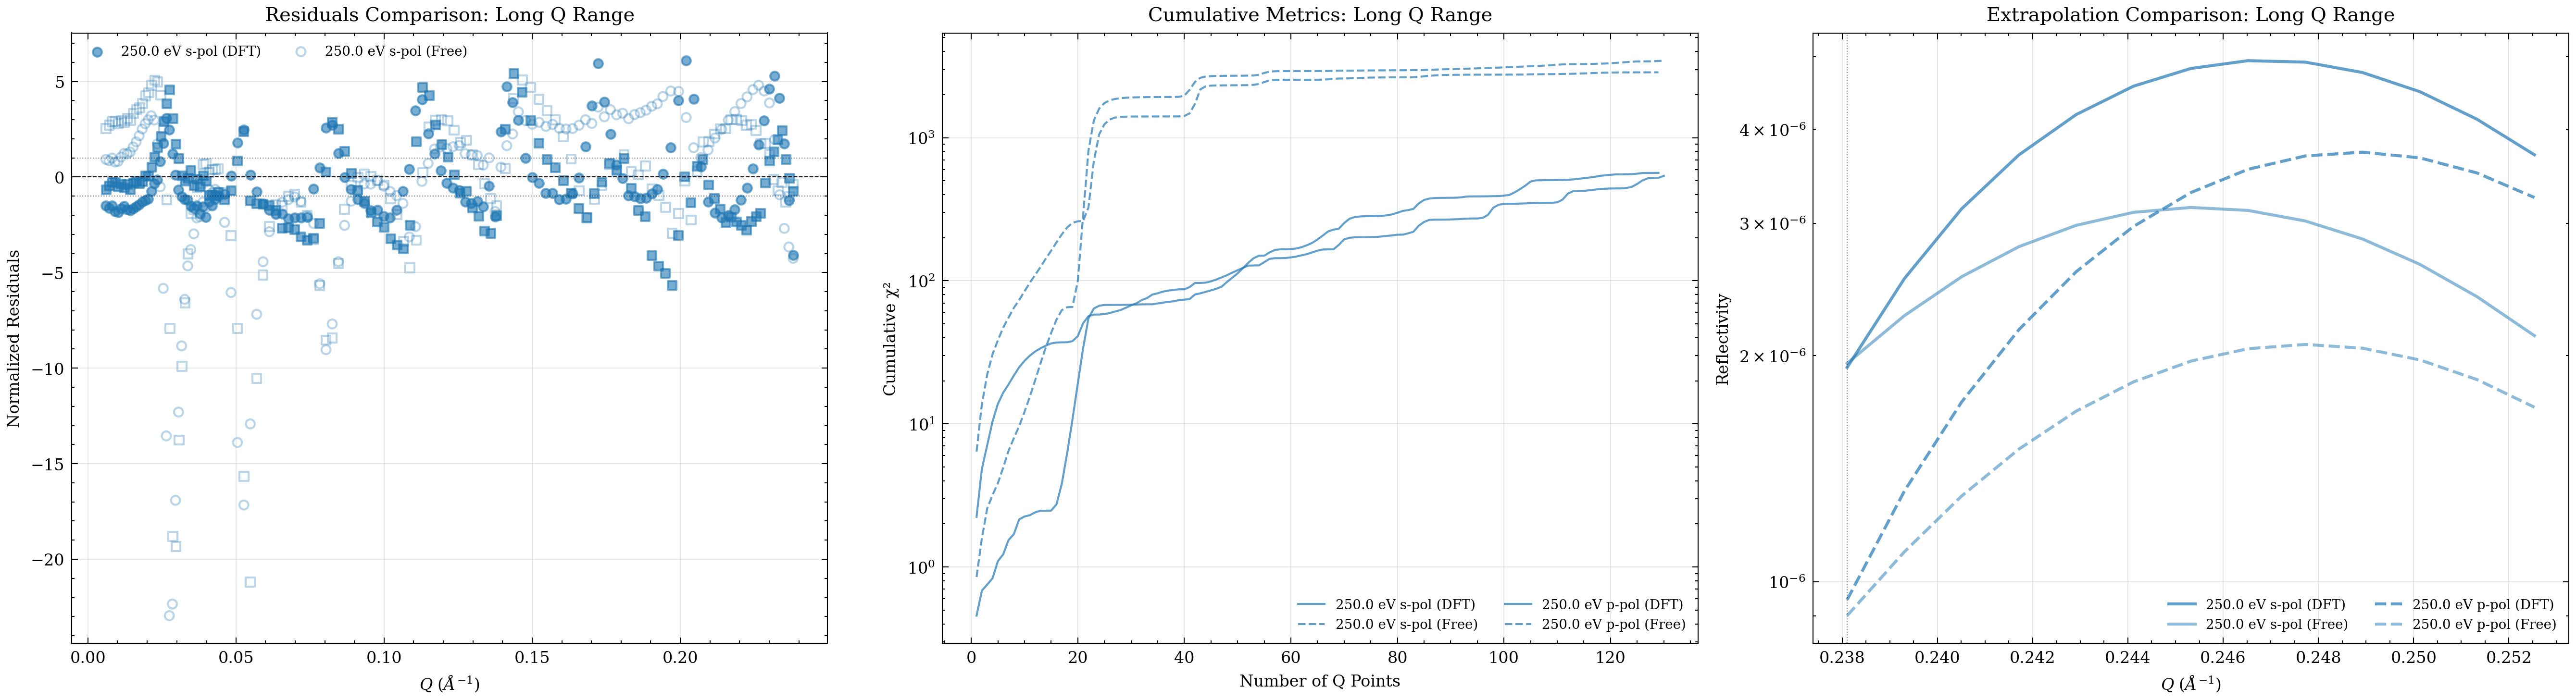


Metrics for Long Q Range:


energy model_type         chi2  reduced_chi2          aic          bic  \
0   250.0        DFT  1278.167830      5.370453  1320.167830  1394.861219   
1   250.0       Free  3859.600828     15.500405  3879.600828  3915.169108   

       rmsd  npoints  nparams  
0  2.221488      259       21  
1  3.860302      259       10

In [8]:
# Analyze long q range energies
long_q_energies = regions['long_q']

if long_q_energies:
    # Use first file pair for analysis
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Residuals
    plot_residuals_comparison(
        objectives_fixed, objectives_free, long_q_energies,
        'Long Q Range', ax=axes[0]
    )

    # Cumulative metrics
    plot_cumulative_metrics(
        objectives_fixed, objectives_free, long_q_energies,
        'Long Q Range', ax=axes[1]
    )

    # Extrapolation
    plot_extrapolation_comparison(
        objectives_fixed, objectives_free, long_q_energies,
        'Long Q Range', ax=axes[2]
    )

    plt.tight_layout()
    plt.show()

    # Metrics table
    print("\nMetrics for Long Q Range:")
    display(metrics_1[metrics_1['energy'].isin(long_q_energies)])
else:
    print("No energies in long q range region")


### Pre-Edge Energies (>250, <283.7)


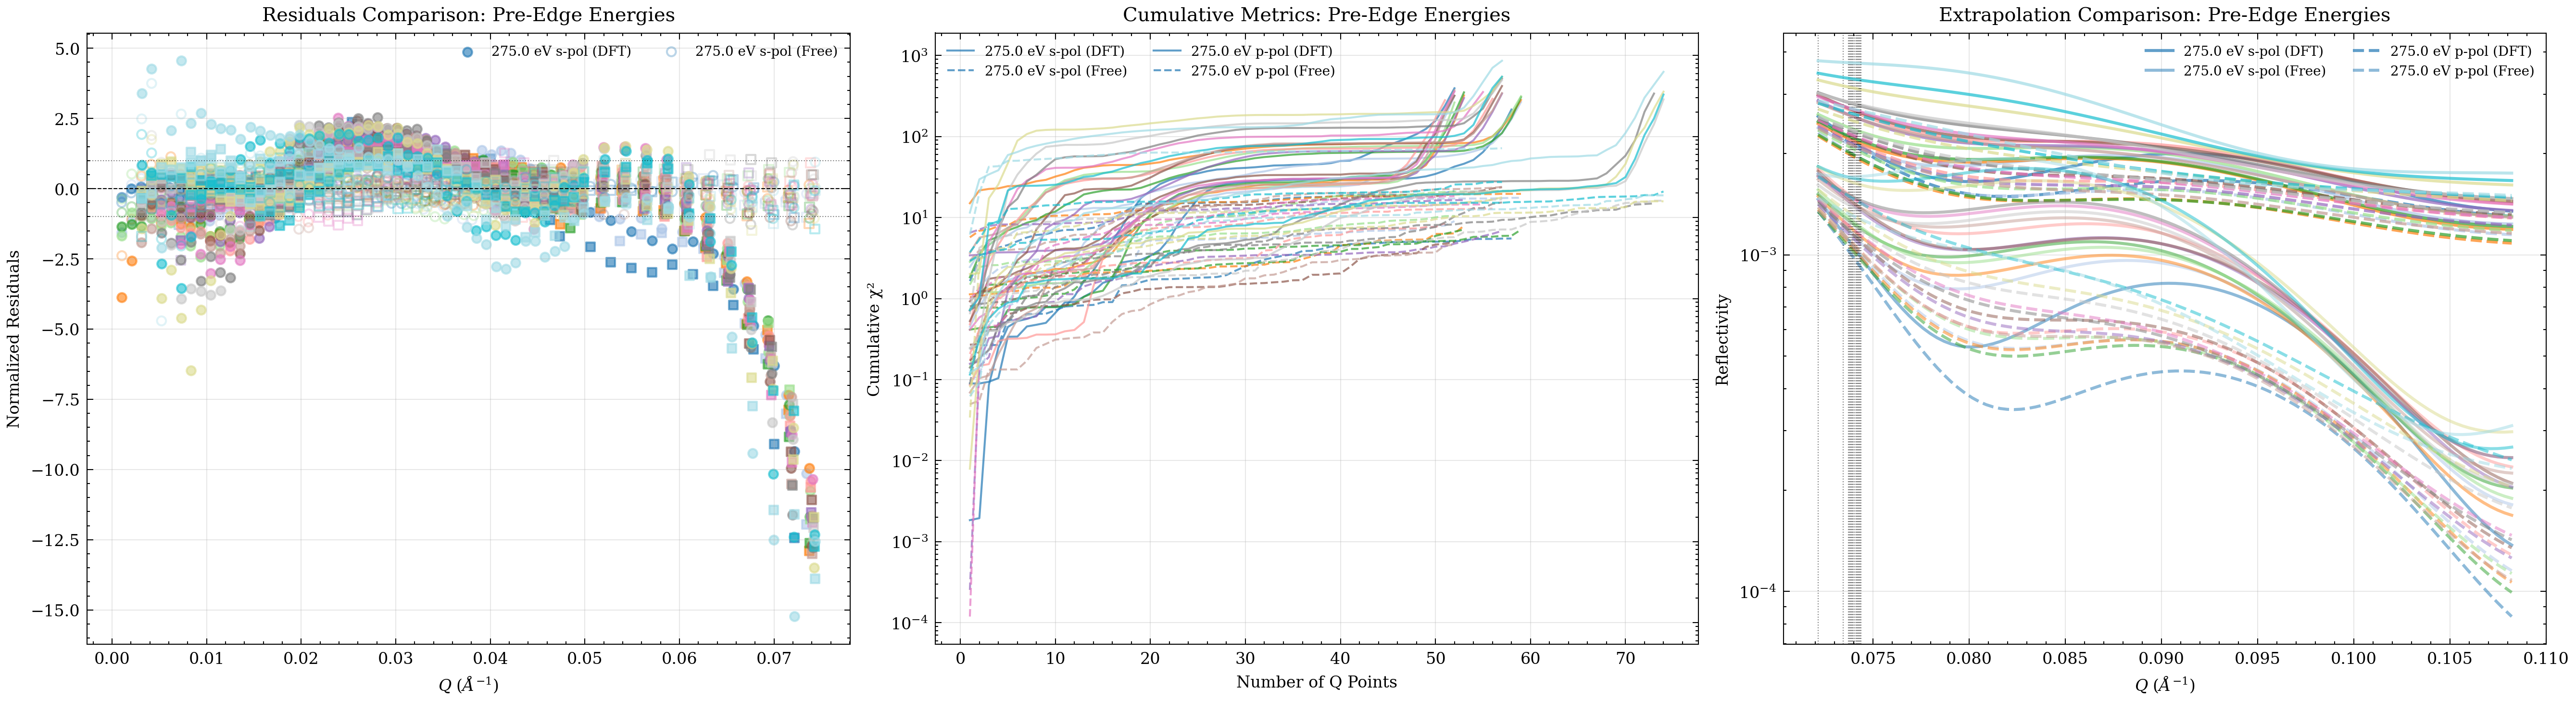


Metrics for Pre-Edge Energies:


energy model_type        chi2  reduced_chi2         aic          bic  \
2    275.0        DFT  411.403759      4.622514  453.403759   510.113846   
3    275.0       Free   26.311980      0.279915   58.311980   101.519665   
4    280.0        DFT  386.697309      4.296637  428.697309   485.597443   
5    280.0       Free   26.785497      0.281953   58.785497   102.137980   
6    281.0        DFT  396.372949      4.355747  438.372949   495.461425   
7    281.0       Free   26.767198      0.278825   58.767198   102.263180   
8    281.2        DFT  421.294965      4.629615  463.294965   520.383441   
9    281.2       Free   13.959190      0.145408   45.959190    89.455172   
10   281.4        DFT  382.195681      4.246619  424.195681   481.095815   
11   281.4       Free   31.961805      0.336440   63.961805   107.314288   
12   281.6        DFT  387.002884      4.500034  429.002884   485.132290   
13   281.6       Free   21.101109      0.231880   53.101109    95.866370   
14   281.8        DFT  414.244997      4.654438  456.244997   512.955085   
15   281.8       Free   21.897810      0.232955   53.897810    97.105496   
16   282.0        DFT  476.813023      5.418330  518.813023   575.331328   
17   282.0       Free   29.448153      0.316647   61.448153   104.509719   
18   282.3        DFT  453.481769      5.153202  495.481769   552.000075   
19   282.3       Free   27.396267      0.291450   57.396267    97.766486   
20   282.5        DFT  476.821970      5.544442  518.821970   574.951375   
21   282.5       Free   32.037149      0.348230   62.037149   102.129581   
22   282.7        DFT  546.812055      5.016624  588.812055   649.030279   
23   282.7       Free   29.632377      0.257673   59.632377   102.645394   
24   282.9        DFT  514.594934      4.678136  556.594934   616.974077   
25   282.9       Free   34.147678      0.296936   66.147678   112.150835   
26   283.1        DFT  580.489934      5.277181  622.489934   682.869078   
27   283.1       Free   34.013505      0.295770   66.013505   112.016662   
28   283.3        DFT  528.128301      4.801166  570.128301   630.507444   
29   283.3       Free   47.392257      0.412107   79.392257   125.395414   
30   283.5        DFT  898.086272      8.164421  940.086272  1000.465416   
31   283.5       Free   91.201388      0.793056  123.201388   169.204546   

        rmsd  npoints  nparams  
2   1.933917      110       21  
3   0.489081      110       16  
4   1.866483      111       21  
5   0.491234      111       16  
6   1.881235      112       21  
7   0.488869      112       16  
8   1.939475      112       21  
9   0.353038      112       16  
10  1.855587      111       21  
11  0.536604      111       16  
12  1.901802      107       21  
13  0.444080      107       16  
14  1.940583      110       21  
15  0.446174      110       16  
16  2.091514      109       21  
17  0.519775      109       16  
18  2.039702      109       21  
19  0.501340      109       15  
20  2.110990      107       21  
21  0.547186      107       15  
22  2.050914      130       21  
23  0.477432      130       15  
24  1.981970      131       21  
25  0.510558      131       16  
26  2.105047      131       21  
27  0.509554      131       16  
28  2.007863      131       21  
29  0.601476      131       16  
30  2.618324      131       21  
31  0.834382      131       16

In [9]:
# Analyze pre-edge energies
pre_edge_energies = regions['pre_edge']

if pre_edge_energies:
    # Use first file pair for analysis
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Residuals
    plot_residuals_comparison(
        objectives_fixed, objectives_free, pre_edge_energies,
        'Pre-Edge Energies', ax=axes[0]
    )

    # Cumulative metrics
    plot_cumulative_metrics(
        objectives_fixed, objectives_free, pre_edge_energies,
        'Pre-Edge Energies', ax=axes[1]
    )

    # Extrapolation
    plot_extrapolation_comparison(
        objectives_fixed, objectives_free, pre_edge_energies,
        'Pre-Edge Energies', ax=axes[2]
    )

    plt.tight_layout()
    plt.show()

    # Metrics table
    print("\nMetrics for Pre-Edge Energies:")
    display(metrics_1[metrics_1['energy'].isin(pre_edge_energies)])
else:
    print("No energies in pre-edge region")


### Resonant Energies (>283.7)


/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/model.py:407: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(x * wavelength / (4 * np.pi)) * 180 / np.pi
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:304: RuntimeWarning: invalid value encountered in divide
  knorm = kvec / kdiv[:, :, None]  # (np.linalg.norm(kvec,axis=-1)[:,:,None])
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:313: RuntimeWarning: invalid value encountered in divide
  ((1 + nu) / (1 + nu * kpol[:, 0, None] ** 2))
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:319: RuntimeWarning: invalid value encountered in divide
  ((1 + nu) / (1 + nu * kpol[:, 1, None] ** 2))
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/uniaxial.py:325: RuntimeWarning: invalid value encountered in divide


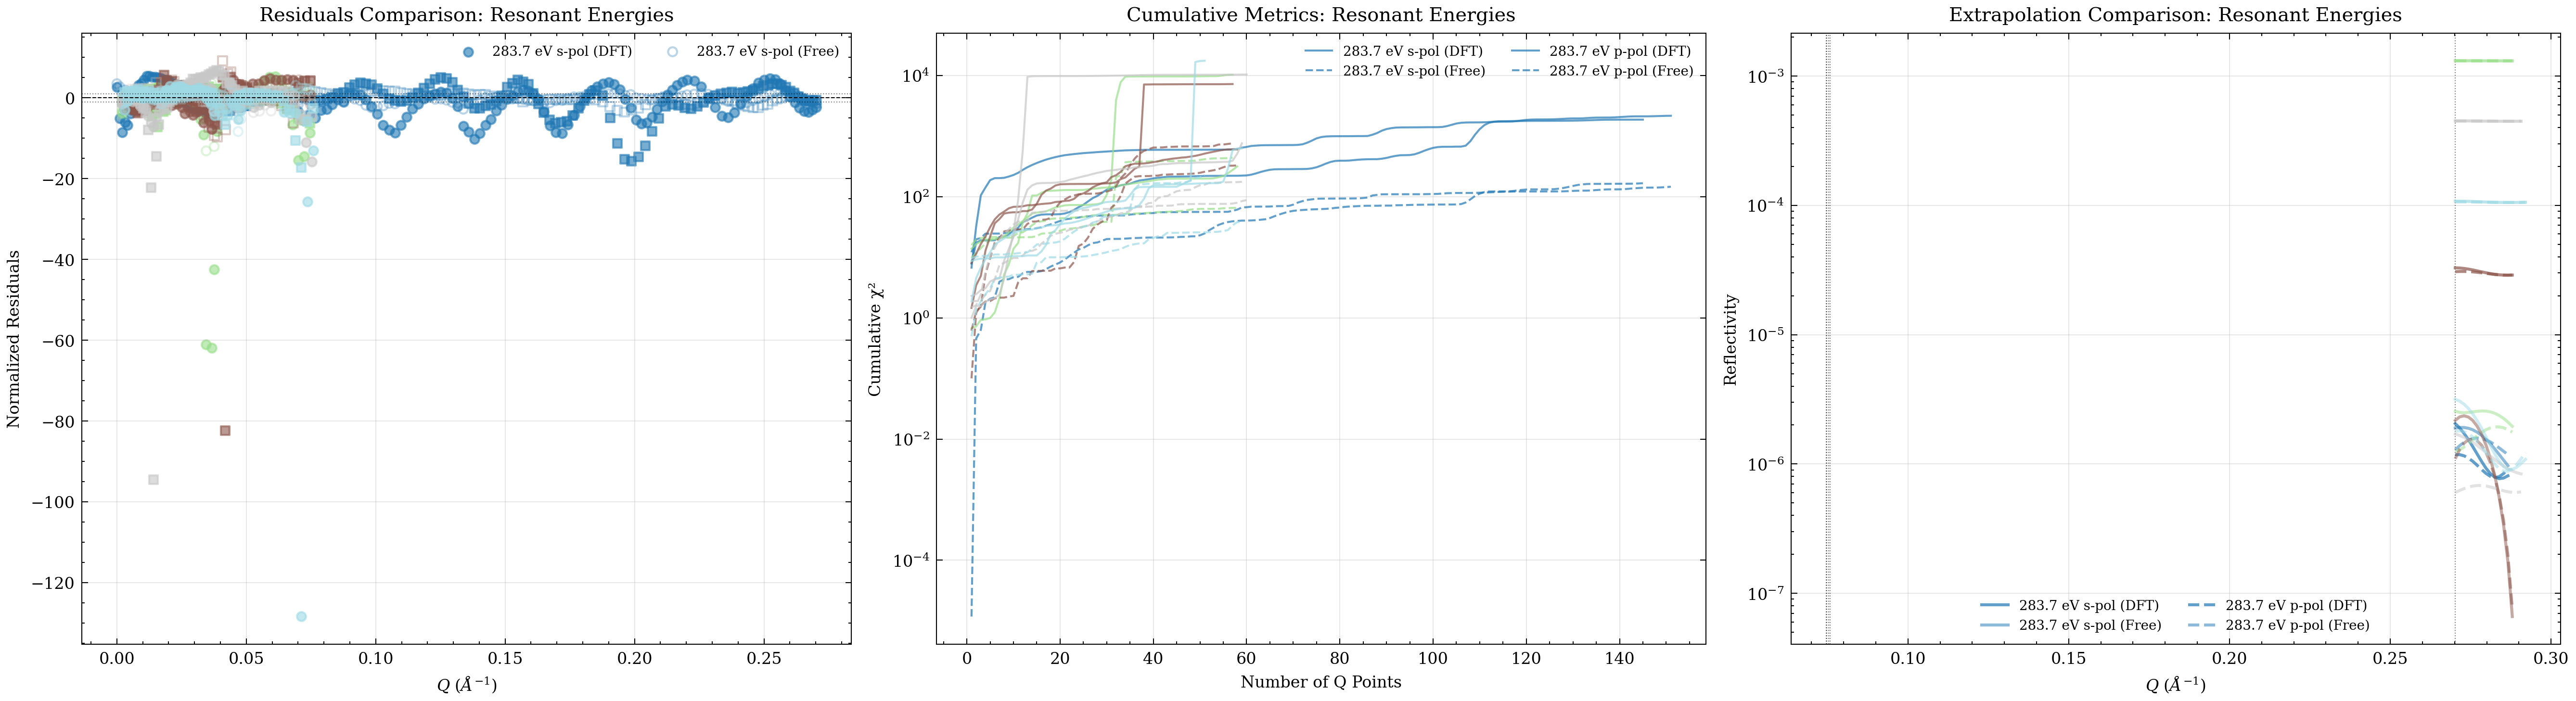


Metrics for Resonant Energies:


energy model_type         chi2  reduced_chi2          aic          bic  \
32   283.7        DFT  3124.115886     11.360421  3166.115886  3243.613434   
33   283.7       Free   294.336743      1.051203   326.336743   385.382495   
34   284.2        DFT  2252.571009     23.963521  2294.571009  2352.214584   
35   284.2       Free   347.557937      3.510686   379.557937   423.476851   
36   285.1        DFT  1741.791214     18.529694  1783.791214  1841.434789   
37   285.1       Free  1116.467514     11.277450  1148.467514  1192.386428   
38   287.0        DFT  2570.485611     26.229445  2612.485611  2670.847205   
39   287.0       Free   269.546068      2.616952   301.546068   346.012044   
40   289.0        DFT  1727.456343     19.409622  1769.456343  1826.166431   
41   289.0       Free   219.539787      2.335530   251.539787   294.747473   

        rmsd  npoints  nparams  
32  3.248761      296       21  
33  0.997186      296       16  
34  4.425785      115       21  
35  1.738460      115       16  
36  3.891788      115       21  
37  3.115833      115       16  
38  4.647657      119       21  
39  1.505023      119       16  
40  3.962846      110       21  
41  1.412734      110       16

In [10]:
# Analyze resonant energies
resonant_energies = regions['resonant']

if resonant_energies:
    # Use first file pair for analysis
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Residuals
    plot_residuals_comparison(
        objectives_fixed, objectives_free, resonant_energies,
        'Resonant Energies', ax=axes[0]
    )

    # Cumulative metrics
    plot_cumulative_metrics(
        objectives_fixed, objectives_free, resonant_energies,
        'Resonant Energies', ax=axes[1]
    )

    # Extrapolation
    plot_extrapolation_comparison(
        objectives_fixed, objectives_free, resonant_energies,
        'Resonant Energies', ax=axes[2]
    )

    plt.tight_layout()
    plt.show()

    # Metrics table
    print("\nMetrics for Resonant Energies:")
    display(metrics_1[metrics_1['energy'].isin(resonant_energies)])
else:
    print("No energies in resonant region")


## Comparison Between File Pairs

Compare results from the two different file pairs to assess consistency.


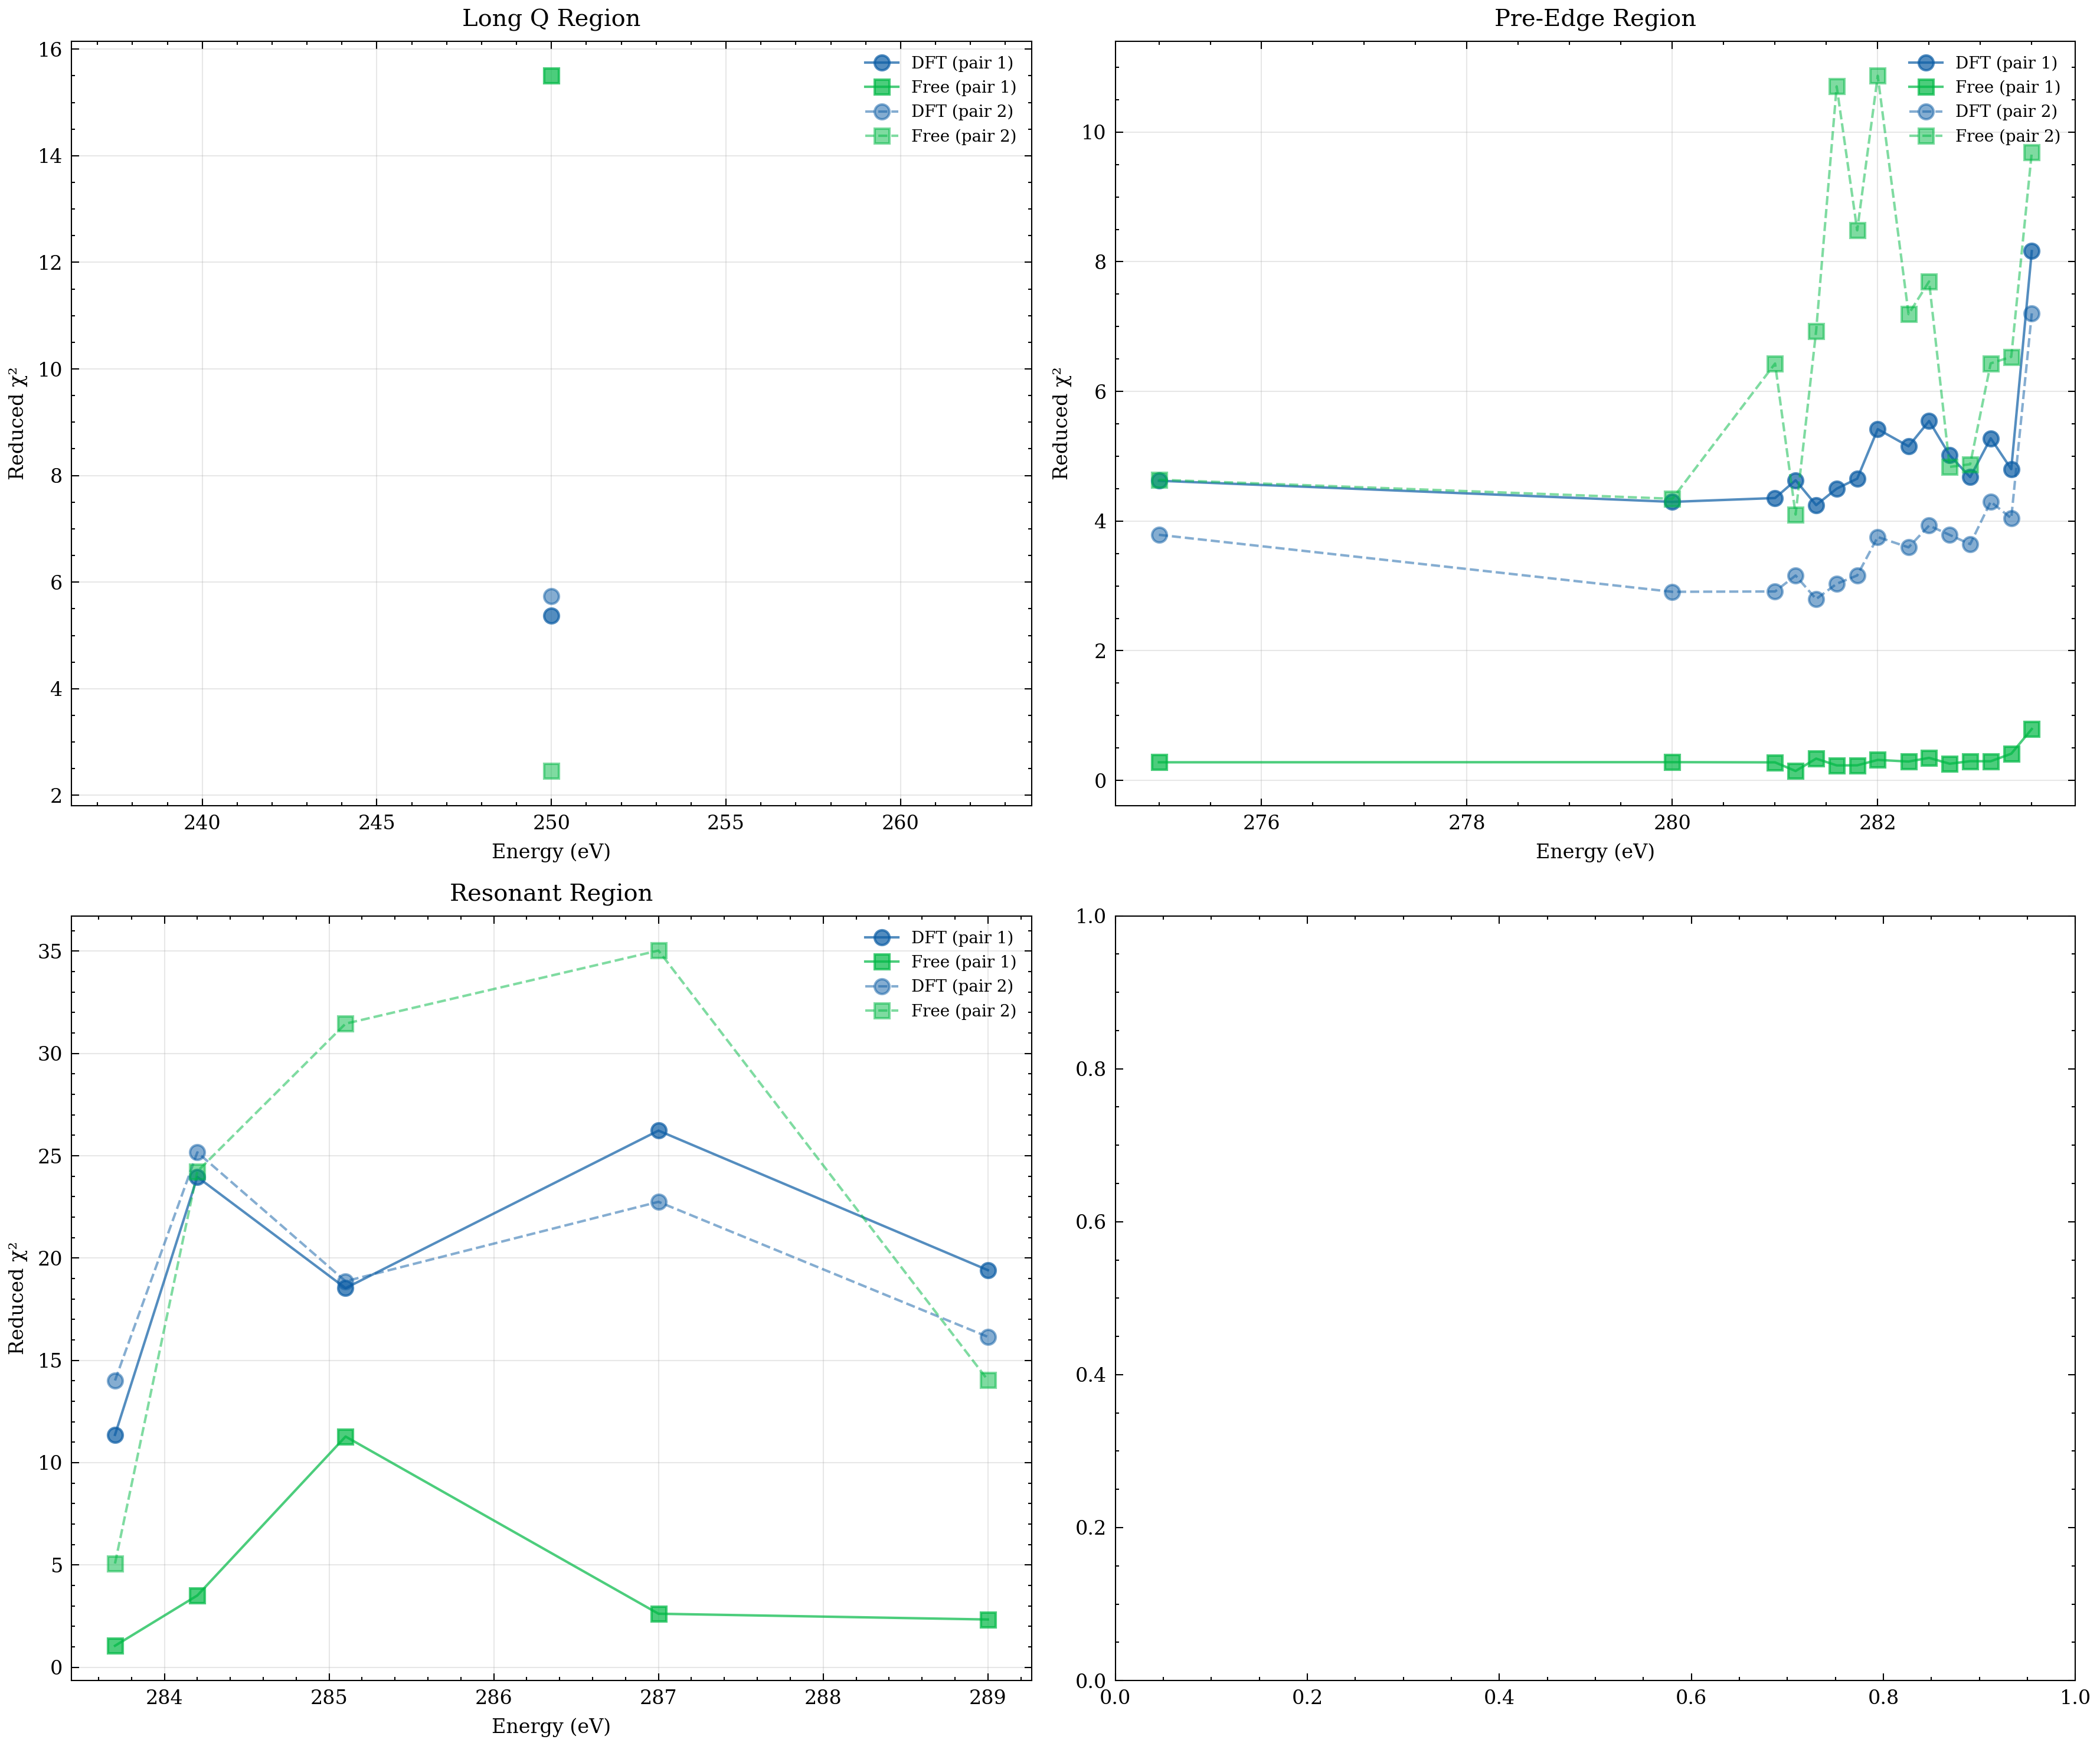

In [11]:
# Compare metrics between file pairs
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Reduced chi2 comparison
for i, (region_name, region_energies) in enumerate([
    ('Long Q', regions['long_q']),
    ('Pre-Edge', regions['pre_edge']),
    ('Resonant', regions['resonant'])
]):
    if not region_energies:
        continue

    ax = axes.flatten()[i]

    # Get metrics for this region
    m1_region = metrics_1[metrics_1['energy'].isin(region_energies)]
    m2_region = metrics_2[metrics_2['energy'].isin(region_energies)]

    if len(m1_region) > 0 and len(m2_region) > 0:
        # Plot reduced chi2
        energies_plot = sorted(set(m1_region['energy'].unique()))
        dft_1 = [m1_region[(m1_region['energy'] == e) & (m1_region['model_type'] == 'DFT')]['reduced_chi2'].values[0]
                 for e in energies_plot if len(m1_region[(m1_region['energy'] == e) & (m1_region['model_type'] == 'DFT')]) > 0]
        free_1 = [m1_region[(m1_region['energy'] == e) & (m1_region['model_type'] == 'Free')]['reduced_chi2'].values[0]
                  for e in energies_plot if len(m1_region[(m1_region['energy'] == e) & (m1_region['model_type'] == 'Free')]) > 0]
        dft_2 = [m2_region[(m2_region['energy'] == e) & (m2_region['model_type'] == 'DFT')]['reduced_chi2'].values[0]
                 for e in energies_plot if len(m2_region[(m2_region['energy'] == e) & (m2_region['model_type'] == 'DFT')]) > 0]
        free_2 = [m2_region[(m2_region['energy'] == e) & (m2_region['model_type'] == 'Free')]['reduced_chi2'].values[0]
                  for e in energies_plot if len(m2_region[(m2_region['energy'] == e) & (m2_region['model_type'] == 'Free')]) > 0]

        energies_plot = [e for e in energies_plot if e in m1_region['energy'].values and e in m2_region['energy'].values]

        if len(energies_plot) > 0:
            ax.plot(energies_plot, dft_1, 'o-', label='DFT (pair 1)', color='C0', alpha=0.7)
            ax.plot(energies_plot, free_1, 's-', label='Free (pair 1)', color='C1', alpha=0.7)
            ax.plot(energies_plot, dft_2, 'o--', label='DFT (pair 2)', color='C0', alpha=0.5)
            ax.plot(energies_plot, free_2, 's--', label='Free (pair 2)', color='C1', alpha=0.5)

        ax.set_xlabel('Energy (eV)')
        ax.set_ylabel('Reduced χ²')
        ax.set_title(f'{region_name} Region')
        ax.legend(fontsize='small')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
